In [ ]:
import torch
import torchvision.datasets as data
import torchvision.transforms as transforms
import random

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [ ]:

# 학습 파라미터 설정
learning_rate = 0.001
training_epochs = 15
batch_size = 100

root: 저장경로
학습/테스트 데이터 선택: True 학습데이터
transform:
download: 


In [ ]:
mnist_train = data.MNIST(root='MNIST_data/',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)

mnist_test = data.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:

data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)


![대체 텍스트](https://user-images.githubusercontent.com/11758940/83336289-229ec200-a2ed-11ea-9fb8-88a51198e475.png)

In [ ]:
# 입력값과 출력값을 고정해둔 상태에서 가운데 값을 결정하는 것은 사용자의 몫
# 보통 2의 배수를 넣는 것이 좋음

linear1 = torch.nn.Linear(784,512,bias=True)
linear2 = torch.nn.Linear(512,512,bias=True)
linear3 = torch.nn.Linear(512,512,bias=True)
linear4 = torch.nn.Linear(512,512,bias=True)
linear5 = torch.nn.Linear(512,10,bias=True)
relu = torch.nn.ReLU()

[메뉴얼] https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_

In [ ]:
# Random Init => Xavier Init
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

Parameter containing:
tensor([[-0.0565,  0.0423, -0.0155,  ...,  0.1012,  0.0459, -0.0191],
        [ 0.0772,  0.0452, -0.0638,  ...,  0.0476, -0.0638,  0.0528],
        [ 0.0311, -0.1023, -0.0701,  ...,  0.0412, -0.1004,  0.0738],
        ...,
        [ 0.0334,  0.0187, -0.1021,  ...,  0.0280, -0.0583, -0.1018],
        [-0.0506, -0.0939, -0.0467,  ..., -0.0554, -0.0325,  0.0640],
        [-0.0183, -0.0123,  0.1025,  ..., -0.0214,  0.0220, -0.0741]],
       requires_grad=True)

In [ ]:
# ======================================
# relu는 맨 마지막 레이어에서 빼는 것이 좋다.
# ======================================
model = torch.nn.Sequential(linear1,relu,
                            linear2,relu,
                            linear3,relu,
                            linear4,relu,
                            linear5).to(device)

[메뉴얼] https://pytorch.org/docs/stable/nn.html#crossentropyloss

In [ ]:
# 손실함수와 최적화 함수
loss = torch.nn.CrossEntropyLoss().to(device) # softmax 내부적으로 계산
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [ ]:

total_batch = len(data_loader)
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:

        # (1000, 1, 28, 28) 크기의 텐서를 (1000, 784) 크기의 텐서로 변형
        X = X.view(-1, 28 * 28).to(device)
        # one-hot encoding되어 있지 않음
        Y = Y.to(device)
        #%debug

        # 그래디언트 초기화
        optimizer.zero_grad()
        # Forward 계산
        hypothesis = model(X)
        # Error 계산
        cost = loss(hypothesis, Y)
        # Backparopagation
        cost.backward()
        # 가중치 갱신
        optimizer.step()

        # 평균 Error 계산
        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.208379686
Epoch: 0002 cost = 0.093098186
Epoch: 0003 cost = 0.062816650
Epoch: 0004 cost = 0.050308373
Epoch: 0005 cost = 0.039831515
Epoch: 0006 cost = 0.034976009
Epoch: 0007 cost = 0.031067850
Epoch: 0008 cost = 0.027449943
Epoch: 0009 cost = 0.025254026
Epoch: 0010 cost = 0.022881333
Epoch: 0011 cost = 0.017714713
Epoch: 0012 cost = 0.019154796
Epoch: 0013 cost = 0.020345032
Epoch: 0014 cost = 0.014153318
Epoch: 0015 cost = 0.013869025
Learning finished


In [ ]:
# Test the model using test sets
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())
u

NameError: ignored

In [ ]:
# 랜덤 테스트
r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

print('Label: ', Y_single_data.item())
single_prediction = model(X_single_data)
print('Prediction: ', torch.argmax(single_prediction, 1).item())

Label:  8
Prediction:  8


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


tensor([8], device='cuda:0')


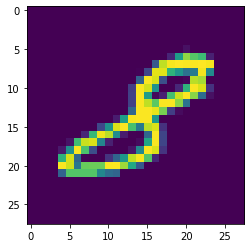

In [ ]:
# 숫자 눈으로 뿌려보기
import matplotlib.pyplot as plt
plt.imshow(X_single_data.reshape(28,28).cpu())
print(Y_single_data)